In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from merlion.utils.time_series import TimeSeries
from ts_datasets.forecast import M4

# Load the time series
# time_series is a time-indexed pandas.DataFrame
# trainval is a time-indexed pandas.Series indicating whether each timestamp is for training or testing
time_series, metadata = M4(subset="Hourly")[0]
trainval = metadata["trainval"]

# Is there any missing data?
timedeltas = np.diff(time_series.index)
print(f"Has missing data: {any(timedeltas != timedeltas[0])}")

# Visualize the time series and draw a dotted line to indicate the train/test split
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)
ax.axvline(time_series[trainval].index[-1], ls="--", lw="2", c="k")
plt.show()
# Split the time series into train/test splits, and convert it to Merlion format
train_data = TimeSeries.from_pd(time_series[trainval])
test_data  = TimeSeries.from_pd(time_series[~trainval])
print(f"{len(train_data)} points in train split, "
      f"{len(test_data)} points in test split.")

In [ ]:
df = pd.read_csv('123456.csv')
data = df.copy()
data['Date'] = pd.to_datetime(data['Date'])
data.dropna(inplace=True)
data.reset_index(drop=True)
data_1 = data[['Date','Close']].copy()
time_index = pd.DatetimeIndex(data_1['Date'].values)
ts_data = data_1.set_index(time_index)
ts_data.drop('Date',axis=1,inplace=True)
ts_data_1 = ts_data[:(int)(len(ts_data)*1)]
train = ts_data_1[:(int)(len(ts_data_1)*0.93)]
test = ts_data_1[(int)(len(ts_data_1)*0.93):]
train_data = TimeSeries.from_pd(train)
test_data =TimeSeries.from_pd(test)
time_series = ts_data_1

In [ ]:
time_series

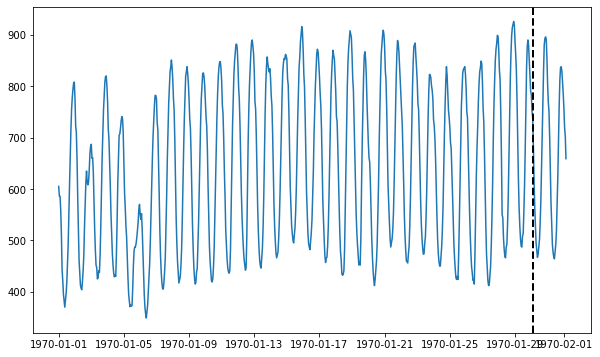

In [3]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)
ax.axvline(time_series[trainval].index[-1], ls="--", lw="2", c="k")
plt.show()

In [4]:
# Import models & configs
from merlion.models.forecast.sarima import Sarima, SarimaConfig
from merlion.models.forecast.arima import Arima, ArimaConfig
from merlion.models.forecast.prophet import Prophet, ProphetConfig
from merlion.models.forecast.smoother import MSES, MSESConfig
from merlion.models.automl.autosarima import AutoSarima, AutoSarimaConfig
from merlion.models.automl.seasonality_mixin import SeasonalityLayer

# Import data pre-processing transforms
from merlion.transform.base import Identity
from merlion.transform.resample import TemporalResample

# All models are initialized using the syntax ModelClass(config),
# where config is a model-specific configuration object. This is where
# you specify any algorithm-specific hyperparameters, as well as any
# data pre-processing transforms.

# ARIMA assumes that input data is sampled at a regular interval,
# so we set its transform to resample at that interval. We must also specify
# a maximum prediction horizon.
config1 = SarimaConfig(max_forecast_steps=100, order=(1,1,1),seasonal_order=(1,1,1,12),
                      transform=TemporalResample(granularity="1h"))
model1  = Sarima(config1)


config2 = ArimaConfig(max_forecast_steps=100, order=(20,1,5),
                      transform=TemporalResample(granularity="1h"))
model2  = Arima(config2)

# Prophet has no real assumptions on the input data (and doesn't require
# a maximum prediction horizon), so we skip data pre-processing by using
# the Identity transform.
config3 = ProphetConfig(max_forecast_steps=None, transform=Identity())
model3  = Prophet(config3)


# MSES assumes that the input data is sampled at a regular interval,
# and requires us to specify a maximum prediction horizon. We will
# also specify its look-back hyperparameter to be 60 here
config4 = MSESConfig(max_forecast_steps=100, max_backstep=60,
                     transform=TemporalResample(granularity="1h"))
model4  = MSES(config4)

config_as = AutoSarimaConfig(max_forecast_steps=len(train_data), order=("auto", "auto", "auto"),
                           seasonal_order=("auto", "auto", "auto", "auto"), approximation=True, maxiter=5)
model_as  = SeasonalityLayer(model = AutoSarima(model = Sarima(config_as)))

In [5]:
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig

# The ForecasterEnsemble is a forecaster, and we treat it as a first-class model.
# Its config takes a combiner object, specifying how you want to combine the
# predictions of individual models in the ensemble. There are two ways to specify
# the actual models in the ensemble, which we cover below.

# The first way to specify the models in the ensemble is to provide their individual
# configs when initializing the ForecasterEnsembleConfig. Note that if using this
# syntax, you must also provide the names of the model classes.
#
# The combiner here will simply take the mean prediction of the ensembles here
ensemble_config = ForecasterEnsembleConfig(
    combiner=Mean(),
    model_configs=[(type(model1).__name__, config1),
                   (type(model2).__name__, config2),
                   (type(model3).__name__, config3),
                   (type(model4).__name__, config4)])
ensemble = ForecasterEnsemble(config=ensemble_config)


# Alternatively, you can skip giving the individual model configs to the
# ForecasterEnsembleConfig, and instead directly specify the models when
# initializing the ForecasterEnsemble itself.
#
# The combiner here uses the sMAPE to compare individual models, and
# selects the model with the lowest sMAPE
selector_config = ForecasterEnsembleConfig(
    combiner=ModelSelector(metric=ForecastMetric.sMAPE))
selector = ForecasterEnsemble(
    config=selector_config, models=[model1, model2, model3,model4])

In [6]:
print(f"Training {type(model1).__name__}...")
forecast1, stderr1 = model1.train(train_data)

print("\nTraining model AutoSarima...")
train_pred, train_err = model_as.train(train_data)



print(f"\nTraining {type(model2).__name__}...")
forecast2, stderr2 = model2.train(train_data)

print(f"\nTraining {type(model3).__name__}...")
forecast3, stderr3 = model3.train(train_data)

print(f"\nTraining {type(model3).__name__}...")
forecast4, stderr4 = model4.train(train_data)

print("\nTraining ensemble...")
forecast_e, stderr_e = ensemble.train(train_data)

print("\nTraining model selector...")
forecast_s, stderr_s = selector.train(train_data)



print("Done!")

Training Sarima...


2021-10-29 20:38:54,793 merlion.models.forecast.base INFO     Automatically detect the periodicity is 24
2021-10-29 20:38:54,864 merlion.models.forecast.sarima INFO     Seasonal difference order is 1
2021-10-29 20:38:54,865 merlion.models.forecast.sarima INFO     Difference order is 0
2021-10-29 20:38:54,933 merlion.models.automl.autosarima INFO     Seasonal difference order is 1
2021-10-29 20:38:54,936 merlion.models.automl.autosarima INFO     Difference order is 0
2021-10-29 20:38:54,999 merlion.models.automl.autosarima INFO     Seasonal difference order is 1



Training model AutoSarima...


2021-10-29 20:38:55,004 merlion.models.automl.autosarima INFO     Difference order is 0
2021-10-29 20:38:55,005 merlion.models.automl.autosarima INFO     Fitting models using approximations(approx_iter is 1) to speed things up
2021-10-29 20:38:55,006 merlion.utils.autosarima_utils DEBUG    Performing stepwise search to minimize aic
2021-10-29 20:38:57,072 merlion.utils.autosarima_utils DEBUG     SARIMA(2,0,2)(1,1,1)[24]    with constant   : AIC=5111.256, Time=2.06 sec
2021-10-29 20:38:57,073 merlion.utils.autosarima_utils DEBUG    First best model found (5111.256)
2021-10-29 20:38:57,333 merlion.utils.autosarima_utils DEBUG     SARIMA(0,0,0)(0,1,0)[24]    with constant   : AIC=7450.065, Time=0.26 sec
2021-10-29 20:38:58,498 merlion.utils.autosarima_utils DEBUG     SARIMA(1,0,0)(1,1,0)[24]    with constant   : AIC=5298.792, Time=1.16 sec
2021-10-29 20:38:59,426 merlion.utils.autosarima_utils DEBUG     SARIMA(0,0,1)(0,1,1)[24]    with constant   : AIC=6839.784, Time=0.93 sec
2021-10-29 2

2021-10-29 20:40:49,085 merlion.utils.autosarima_utils DEBUG    New best model found (4797.174 < 4798.744)
2021-10-29 20:40:51,042 merlion.utils.autosarima_utils DEBUG    Near non-invertible roots for order (1, 0, 5)(0, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.001)
2021-10-29 20:40:51,043 merlion.utils.autosarima_utils DEBUG     SARIMA(1,0,5)(0,1,1)[24] without constant   : AIC=inf, Time=1.96 sec
2021-10-29 20:40:57,522 merlion.utils.autosarima_utils DEBUG    Near non-invertible roots for order (1, 0, 5)(1, 1, 2, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.002)
2021-10-29 20:40:57,532 merlion.utils.autosarima_utils DEBUG     SARIMA(1,0,5)(1,1,2)[24] without constant   : AIC=inf, Time=6.49 sec
2021-10-29 20:40:59,238 merlion.utils.autosarima_utils DEBUG     SARIMA(1,0,5)(1,1,1)[24] without constant   : AIC=5077.336, Time=1.70 sec
2021-10-29 20:41:04,005 merlion.utils.au


Training Arima...


2021-10-29 20:41:38,806 merlion.models.forecast.prophet INFO     Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Training Prophet...

Training Prophet...


2021-10-29 20:41:43,539 merlion.models.ensemble.forecast INFO     Training model 1/4...



Training ensemble...


2021-10-29 20:41:45,419 merlion.models.ensemble.forecast INFO     Training model 2/4...
2021-10-29 20:41:53,313 merlion.models.ensemble.forecast INFO     Training model 3/4...
2021-10-29 20:41:53,317 merlion.models.forecast.prophet INFO     Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2021-10-29 20:41:54,797 merlion.models.ensemble.forecast INFO     Training model 4/4...
2021-10-29 20:41:58,044 merlion.models.ensemble.forecast INFO     Training model 1/4...



Training model selector...


2021-10-29 20:41:59,071 merlion.models.ensemble.forecast INFO     Training model 2/4...
2021-10-29 20:42:05,494 merlion.models.ensemble.forecast INFO     Training model 3/4...
2021-10-29 20:42:05,497 merlion.models.forecast.prophet INFO     Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2021-10-29 20:42:06,239 merlion.models.ensemble.forecast INFO     Training model 4/4...
2021-10-29 20:42:08,551 merlion.models.ensemble.forecast INFO     Evaluating validation performance...
Validation: 100%|██████████████████████████████████████████████████████████| 500400/500400 [00:01<00:00, 269889.16it/s]
2021-10-29 20:42:10,514 merlion.models.ensemble.forecast INFO     Re-training model 1/4 on full data...
2021-10-29 20:42:12,356 merlion.models.ensemble.forecast INFO     Re-training model 2/4 on full data...
2021-10-29 20:42:20,589 merlion.models.ensemble.forecast INFO     Re-training model 3/4 on full data...
2021-10-29 20

Done!


In [8]:
# Truncate the test data to ensure that we are within each model's maximum
# forecast horizon.
sub_test_data = test_data[:50]

# Obtain the time stamps corresponding to the test data
time_stamps = sub_test_data.univariates[sub_test_data.names[0]].time_stamps

# Get the forecast & standard error of each model. These are both
# merlion.utils.TimeSeries objects. Note that the standard error is None for
# models which don't support uncertainty estimation (like MSES and all
# ensembles).
forecast1, stderr1 = model1.forecast(time_stamps=time_stamps)
forecast2, stderr2 = model2.forecast(time_stamps=time_stamps)

# You may optionally specify a time series prefix as context. If one isn't
# specified, the prefix is assumed to be the training data. Here, we just make
# this dependence explicit. More generally, this feature is useful if you want
# to use a pre-trained model to make predictions on data further in the future
# from the last time it was trained.
forecast3, stderr3 = model3.forecast(time_stamps=time_stamps, time_series_prev=train_data)
forecast4, stderr4 = model4.forecast(time_stamps=time_stamps, time_series_prev=train_data)

# The same options are available for ensembles as well, though the stderr is None
forecast_e, stderr_e = ensemble.forecast(time_stamps=time_stamps)
forecast_s, stderr_s = selector.forecast(time_stamps=time_stamps)

forecast_as, stderr_as = model_as.forecast(len(test_data))

In [13]:
from merlion.evaluate.forecast import ForecastMetric

# We begin by computing the sMAPE of ARIMA's forecast (scale is 0 to 100)
smape1 = ForecastMetric.sMAPE.value(ground_truth=sub_test_data,
                                    predict=forecast1)
smape2 = ForecastMetric.sMAPE.value(ground_truth=sub_test_data,
                                    predict=forecast2)
smape3 = ForecastMetric.sMAPE.value(ground_truth=sub_test_data,
                                    predict=forecast3)
smape4 = ForecastMetric.sMAPE.value(ground_truth=sub_test_data,
                                    predict=forecast4)
smape_e = ForecastMetric.sMAPE.value(ground_truth=sub_test_data,
                                    predict=forecast_e)
smape_s = ForecastMetric.sMAPE.value(sub_test_data, forecast_s)

smape_as = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=forecast_as)

rmse1 = ForecastMetric.RMSE.value(ground_truth=sub_test_data,
                                    predict=forecast1)
rmse2 = ForecastMetric.RMSE.value(ground_truth=sub_test_data,
                                    predict=forecast2)
rmse3 = ForecastMetric.RMSE.value(ground_truth=sub_test_data,
                                    predict=forecast3)
rmse4 = ForecastMetric.RMSE.value(ground_truth=sub_test_data,
                                    predict=forecast4)
rmse_e = ForecastMetric.RMSE.value(ground_truth=sub_test_data,
                                    predict=forecast_e)
rmse_s = ForecastMetric.RMSE.value(ground_truth=sub_test_data,
                                    predict=forecast_s)
rmse_as = ForecastMetric.RMSE.value(ground_truth=test_data, predict=forecast_as)
print(f"{type(model1).__name__} RMSE is {rmse1:.3f}")
print(f"{type(model2).__name__} RMSE is {rmse2:.3f}")
print(f"{type(model3).__name__} RMSE is {rmse3:.3f}")
print(f"{type(model4).__name__} RMSE is {rmse4:.3f}")
print(f"{type(ensemble).__name__} RMSE is {rmse_e:.3f}")
print(f"Selector RMSE is {rmse_s:.3f}")
print(f"Full AutoSarima with approximation RMSE is {rmse_as:.4f}")

print('-----------------------')
print(f"{type(model1).__name__} sMAPE is {smape1:.3f}")
print(f"{type(model2).__name__} sMAPE is {smape2:.3f}")
print(f"{type(model3).__name__} sMAPE is {smape3:.3f}")
print(f"{type(model4).__name__} sMAPE is {smape4:.3f}")
print(f"{type(ensemble).__name__} sMAPE is {smape_e:.3f}")
print(f"Selector sMAPE is {smape_s:.3f}")
print(f"Full AutoSarima with approximation sMAPE is {smape_as:.4f}")

Sarima RMSE is 70.293
Arima RMSE is 36.670
Prophet RMSE is 32.065
MSES RMSE is 191.494
ForecasterEnsemble RMSE is 56.299
Selector RMSE is 32.065
Full AutoSarima with approximation RMSE is 27.6091
-----------------------
Sarima sMAPE is 7.809
Arima sMAPE is 5.002
Prophet sMAPE is 3.715
MSES sMAPE is 35.029
ForecasterEnsemble sMAPE is 7.765
Selector sMAPE is 3.715
Full AutoSarima with approximation sMAPE is 3.4972


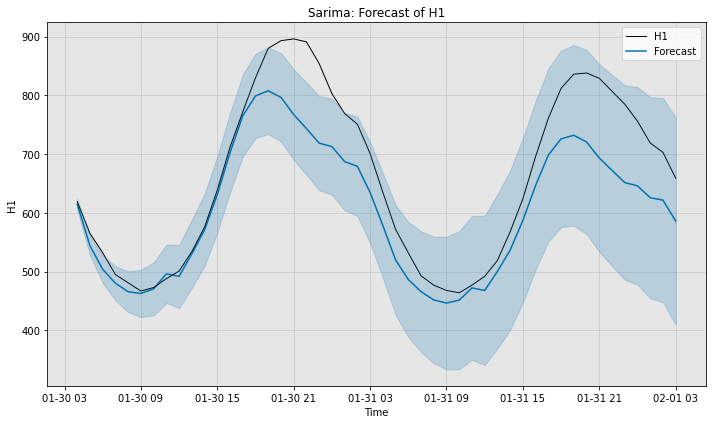

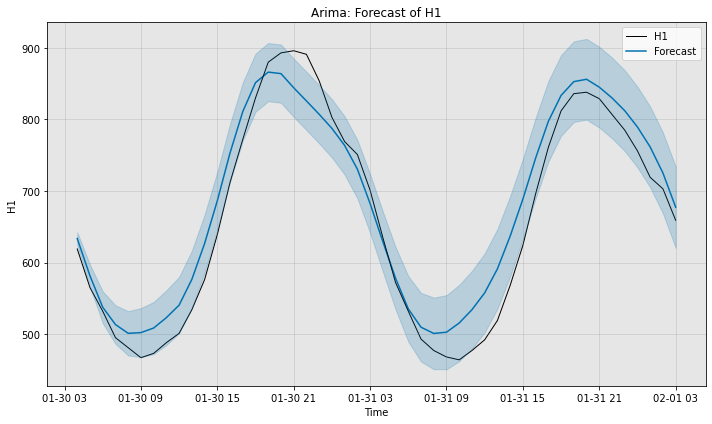

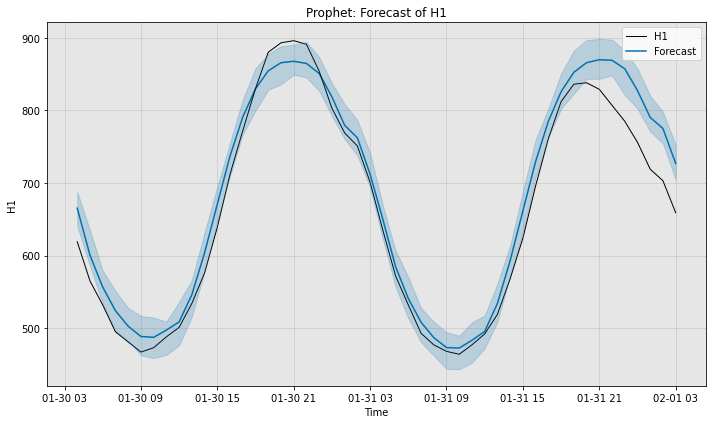

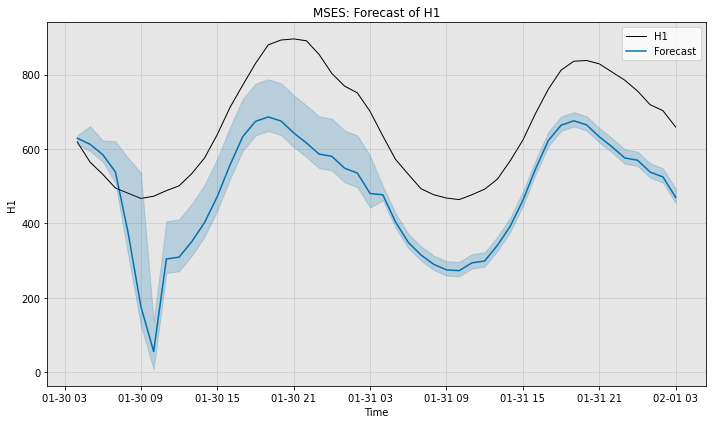

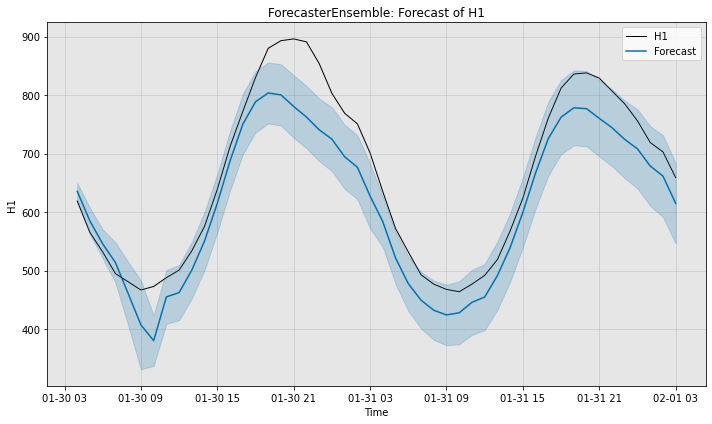

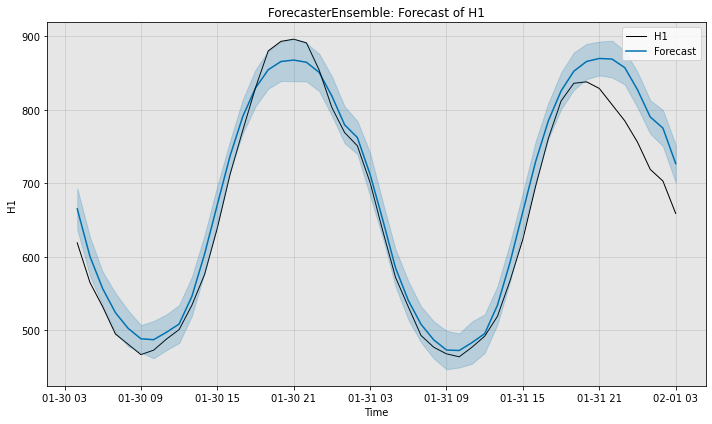

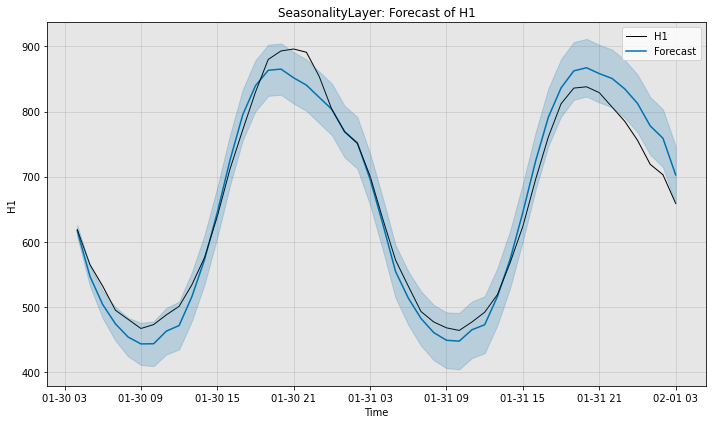

In [13]:
# Visualize the forecast.
fig, ax = model1.plot_forecast(time_series=sub_test_data,
                                 plot_forecast_uncertainty=True)
fig, ax = model2.plot_forecast(time_series=sub_test_data,
                                 plot_forecast_uncertainty=True)
fig, ax = model3.plot_forecast(time_series=sub_test_data,
                                 plot_forecast_uncertainty=True)
fig, ax = model4.plot_forecast(time_series=sub_test_data,
                                 plot_forecast_uncertainty=True)
fig, ax = ensemble.plot_forecast(time_series=sub_test_data,
                                 plot_forecast_uncertainty=True)
fig, ax = selector.plot_forecast(time_series=sub_test_data,
                                 plot_forecast_uncertainty=True)
fig, ax = model_as.plot_forecast(time_series=test_data,
                                 plot_forecast_uncertainty=True)
plt.show()

In [23]:
import json
import os
import pprint
from merlion.models.factory import ModelFactory

# Save the model
os.makedirs("models", exist_ok=True)
path = os.path.join("models", "AutoSarima")
model_as.save(path)

# Print the config saved
pp = pprint.PrettyPrinter()
with open(os.path.join(path, "config.json")) as f:
    print(f"{type(model_as).__name__} Config")
    pp.pprint(json.load(f))

# # Load the model using Prophet.load()
# model2_loaded = Arima.load(dirname=path)

# # Load the model using the ModelFactory
# model2_factory_loaded = ModelFactory.load(name="Arima", model_path=path)

SeasonalityLayer Config
{'model_name': 'AutoSarima'}
